In [37]:
#Mount my drive- run the code, go to the link, accept.
from google.colab import drive
drive.mount('/content/gdrive')

#Change working directory to make it easier to access the files
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/dinn")
os.getcwd() 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/My Drive/Colab Notebooks/dinn'

In [38]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

smallpox_data = genfromtxt('smallpox.csv', delimiter=',') #in the form of [t, S ,En ,Ei ,Ci ,I ,Q ,U, V]

torch.manual_seed(1234)

In [39]:
%%time

PATH = 'smallpox' 

class DINN(nn.Module):
    def __init__(self, t, S_data, En_data, Ei_data, Ci_data, I_data, Q_data, U_data, V_data):
        super(DINN, self).__init__()
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.S = torch.tensor(S_data)
        self.En = torch.tensor(En_data)
        self.Ei = torch.tensor(Ei_data)
        self.Ci = torch.tensor(Ci_data)
        self.I = torch.tensor(I_data)
        self.Q = torch.tensor(Q_data)
        self.U = torch.tensor(U_data)
        self.V = torch.tensor(V_data)

        self.losses = [] #keep the losses
        self.save = 3 #which file to save to

        #learnable parameters
        self.chi_1_tilda = torch.tensor(0.06)
        self.chi_2_tilda = torch.tensor(0.04)
        self.epsilon_1_tilda = torch.tensor(0.975)
        self.epsilon_2_tilda = torch.tensor(0.3)
        self.rho_tilda = torch.tensor(0.975)
        self.theta_tilda = torch.tensor(0.95)
        self.alpha_tilda = torch.tensor(0.0685)
        self.gamma_tilda = torch.tensor(0.116)
        self.N = torch.tensor(7000)

        #matrices (x8 for S ,En ,Ei ,Ci ,I ,Q ,U, V) for the gradients
        self.m1 = torch.zeros((len(self.t), 8)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 8)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 8)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 8)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 8)); self.m5[:, 4] = 1
        self.m6 = torch.zeros((len(self.t), 8)); self.m6[:, 5] = 1
        self.m7 = torch.zeros((len(self.t), 8)); self.m7[:, 6] = 1
        self.m8 = torch.zeros((len(self.t), 8)); self.m8[:, 7] = 1

        #values for norm
        self.S_max = max(self.S)
        self.S_min = min(self.S)
        self.En_max = max(self.En)
        self.En_min = min(self.En)
        self.Ei_max = max(self.Ei)
        self.Ei_min = min(self.Ei)
        self.Ci_max = max(self.Ci)
        self.Ci_min = min(self.Ci)
        self.I_max = max(self.I)
        self.I_min = min(self.I)
        self.Q_max = max(self.Q)
        self.Q_min = min(self.Q)
        self.U_max = max(self.U)
        self.U_min = min(self.U)
        self.V_max = max(self.V)
        self.V_min = min(self.V)

        #normalize 
        self.S_hat = (self.S - self.S_min)/(self.S_max - self.S_min)
        self.En_hat = (self.En - self.En_min)/(self.En_max - self.En_min)
        self.Ei_hat = (self.Ei - self.Ei_min)/(self.Ei_max - self.Ei_min)
        self.Ci_hat = (self.Ci - self.Ci_min)/(self.Ci_max - self.Ci_min)
        self.I_hat = (self.I - self.I_min)/(self.I_max - self.I_min)
        self.Q_hat = (self.Q - self.Q_min)/(self.Q_max - self.Q_min)
        self.U_hat = (self.U - self.U_min)/(self.U_max - self.U_min)
        self.V_hat = (self.V - self.V_min)/(self.V_max - self.V_min)


        #NN
        self.net_smallpox = self.Net_smallpox()
        self.params = list(self.net_smallpox.parameters())
        self.params.extend(list([self.chi_1_tilda ,self.chi_2_tilda ,self.epsilon_1_tilda ,self.epsilon_2_tilda ,self.rho_tilda ,self.theta_tilda ,self.alpha_tilda ,self.gamma_tilda]))

        
    #force parameters to be in a range
    
    @property
    def chi_1(self):
        return self.chi_1_tilda
    @property
    def chi_2(self):
        return self.chi_2_tilda
    @property
    def epsilon_1(self):
        return self.epsilon_1_tilda
    @property
    def epsilon_2(self):
        return self.epsilon_2_tilda
    @property
    def rho(self):
        return self.rho_tilda
    @property
    def theta(self):
        return self.theta_tilda
    @property
    def alpha(self):
        return self.alpha_tilda
    @property
    def gamma(self):
        return self.gamma_tilda

    #nets
    class Net_smallpox(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_smallpox, self).__init__()
            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 8) #outputs S ,En ,Ei ,Ci ,I ,Q ,U, V

        def forward(self, t):
            smallpox=F.relu(self.fc1(t))
            smallpox=F.relu(self.fc2(smallpox))
            smallpox=F.relu(self.fc3(smallpox))
            smallpox=F.relu(self.fc4(smallpox))
            smallpox=F.relu(self.fc5(smallpox))
            smallpox=F.relu(self.fc6(smallpox))
            smallpox=F.relu(self.fc7(smallpox))
            smallpox=F.relu(self.fc8(smallpox))
            smallpox=self.out(smallpox)
            return smallpox    

    def net_f(self, t_batch):       

        smallpox_hat = self.net_smallpox(t_batch)

        S_hat ,En_hat ,Ei_hat ,Ci_hat ,I_hat ,Q_hat ,U_hat ,V_hat = smallpox_hat[:,0], smallpox_hat[:,1], smallpox_hat[:,2], smallpox_hat[:,3], smallpox_hat[:,4], smallpox_hat[:,5], smallpox_hat[:,6], smallpox_hat[:,7]

        #S_hat
        smallpox_hat.backward(self.m1, retain_graph=True)
        S_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #En_hat
        smallpox_hat.backward(self.m2, retain_graph=True)
        En_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Ei_hat
        smallpox_hat.backward(self.m3, retain_graph=True)
        Ei_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Ci_hat
        smallpox_hat.backward(self.m4, retain_graph=True)
        Ci_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_hat
        smallpox_hat.backward(self.m5, retain_graph=True)
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Q_hat
        smallpox_hat.backward(self.m6, retain_graph=True)
        Q_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #U_hat
        smallpox_hat.backward(self.m7, retain_graph=True)
        U_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #V_hat
        smallpox_hat.backward(self.m8, retain_graph=True)
        V_hat_t = self.t.grad.clone()
        self.t.grad.zero_()


        #unnormalize
        S = self.S_min + (self.S_max - self.S_min) * S_hat
        En = self.En_min + (self.En_max - self.En_min) * En_hat
        Ei = self.Ei_min + (self.Ei_max - self.Ei_min) * Ei_hat
        Ci = self.Ci_min + (self.Ci_max - self.Ci_min) * Ci_hat
        I = self.I_min + (self.I_max - self.I_min) * I_hat
        Q = self.Q_min + (self.Q_max - self.Q_min) * Q_hat
        U = self.U_min + (self.U_max - self.U_min) * U_hat
        V = self.V_min + (self.V_max - self.V_min) * V_hat

        #equations
        phi = self.I/self.S
        beta = (torch.tensor(10) * self.gamma)/(phi*self.N)

        f1_hat = S_hat_t - (self.chi_1 * (1-self.epsilon_1) * Ci - beta * (phi + self.rho - phi * self.rho) * S * I) / (self.S_max - self.S_min)
        f2_hat = En_hat_t - (beta * phi * (1-self.rho)*S*I - self.alpha*En) / (self.En_max - self.En_min)
        f3_hat = Ei_hat_t - (beta * phi*self.rho*S*I - (self.chi_1*self.epsilon_2 + self.alpha*(1-self.epsilon_2))*Ei) / (self.Ei_max - self.Ei_min)
        f4_hat = Ci_hat_t - (beta*self.rho*(1-phi)*S*I-self.chi_1*Ci) / (self.Ci_max - self.Ci_min)
        f5_hat = I_hat_t - (self.alpha*(1-self.theta)*En- (self.theta+self.gamma)*I) / (self.I_max - self.I_min)
        f6_hat = Q_hat_t - (self.alpha*(1-self.epsilon_2)*Ei+self.theta*(self.alpha*En+I)-self.chi_2*Q) / (self.Q_max - self.Q_min)
        f7_hat = U_hat_t - (self.gamma*I+self.chi_2*Q) / (self.U_max - self.U_min)
        f8_hat = V_hat_t - (self.chi_1*(self.epsilon_2*Ei+self.epsilon_1*Ci) ) / (self.V_max - self.V_min)

        return f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, f6_hat, f7_hat, f8_hat, S_hat ,En_hat ,Ei_hat ,Ci_hat ,I_hat ,Q_hat ,U_hat ,V_hat
    
    def load(self):
      # Load checkpoint
      try:
        checkpoint = torch.load(PATH + str(self.save)+'.pt') 
        print('\nloading pre-trained model...')
        self.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        self.losses = checkpoint['losses']
        print('loaded previous loss: ', loss)
      except RuntimeError :
          print('changed the architecture, ignore')
          pass
      except FileNotFoundError:
          pass

    def train(self, n_epochs):
      #try loading
      self.load()

      #train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        #lists to hold the output (maintain only the final epoch)
        S_pred_list = []
        En_pred_list = []
        Ei_pred_list = []
        Ci_pred_list = []
        I_pred_list = []
        Q_pred_list = []
        U_pred_list = []
        V_pred_list = []

        f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, f6_hat, f7_hat, f8_hat, S_hat_pred ,En_hat_pred ,Ei_hat_pred ,Ci_hat_pred ,I_hat_pred ,Q_hat_pred ,U_hat_pred ,V_hat_pred = self.net_f(self.t_batch)
        self.optimizer.zero_grad()

        S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_hat_pred)
        En_pred_list.append(self.En_min + (self.En_max - self.En_min) * En_hat_pred)
        Ei_pred_list.append(self.Ei_min + (self.Ei_max - self.Ei_min) * Ei_hat_pred)
        Ci_pred_list.append(self.Ci_min + (self.Ci_max - self.Ci_min) * Ci_hat_pred)
        I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_hat_pred)
        Q_pred_list.append(self.Q_min + (self.Q_max - self.Q_min) * Q_hat_pred)
        U_pred_list.append(self.U_min + (self.U_max - self.U_min) * U_hat_pred)
        V_pred_list.append(self.V_min + (self.V_max - self.V_min) * V_hat_pred)

        loss = (
              torch.mean(torch.square(self.S_hat - S_hat_pred)) + torch.mean(torch.square(self.En_hat - En_hat_pred)) + 
              torch.mean(torch.square(self.Ei_hat - Ei_hat_pred)) + torch.mean(torch.square(self.Ci_hat - Ci_hat_pred)) +
              torch.mean(torch.square(self.I_hat - I_hat_pred)) + torch.mean(torch.square(self.Q_hat - Q_hat_pred)) + 
              torch.mean(torch.square(self.U_hat - U_hat_pred)) + torch.mean(torch.square(self.V_hat - V_hat_pred)) +
              torch.mean(torch.square(f1_hat)) + torch.mean(torch.square(f2_hat)) +
              torch.mean(torch.square(f3_hat)) + torch.mean(torch.square(f4_hat)) +
              torch.mean(torch.square(f5_hat)) + torch.mean(torch.square(f6_hat)) +
              torch.mean(torch.square(f7_hat)) + torch.mean(torch.square(f8_hat)) 
               )

        loss.backward()

        self.optimizer.step()
        #self.scheduler.step() 
        self.scheduler.step(loss) 

        self.losses.append(loss.item())

        if epoch % 1000 == 0:          
          print('\nEpoch ', epoch)

        #loss + model parameters update
        if epoch % 4000 == 0:
          #checkpoint save every 1000 epochs if the loss is lower
          print('\nSaving model... Loss is: ', loss)
          torch.save({
              'epoch': epoch,
              'model': self.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'scheduler': self.scheduler.state_dict(),
              'loss': loss,
              'losses': self.losses,
              }, PATH + str(self.save)+'.pt')
          if self.save % 2 > 0: #its on 3
            self.save = 2 #change to 2
          else: #its on 2
            self.save = 3 #change to 3

          print('epoch: ', epoch)
          # print('alpha1: (goal 1)', self.alpha1)
          # print('\nalpha2: (goal 0)', self.alpha2)
          # print('\nbeta: (goal 0.0075): ', beta)
          # print('\nmu (goal 5): ', self.mu)
          # print('\nu: (goal 0.515151515): ', self.u)
          # print('\ntao (goal 0.58): ', self.tao)
          print('#################################')
        
      #plot
      plt.plot(self.losses, color = 'teal')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      return  S_pred_list ,En_pred_list ,Ei_pred_list ,Ci_pred_list ,I_pred_list ,Q_pred_list ,U_pred_list ,V_pred_list

CPU times: user 48 µs, sys: 0 ns, total: 48 µs
Wall time: 52.5 µs



loading pre-trained model...
loaded previous loss:  tensor(0.0155, dtype=torch.float64, requires_grad=True)

starting training...


Epoch  0

Saving model... Loss is:  tensor(0.0155, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  0
#################################
Epoch 40765: reducing learning rate of group 0 to 4.4371e-04.

Epoch  1000

Epoch  2000

Epoch  3000

Epoch  4000

Saving model... Loss is:  tensor(0.0157, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  4000
#################################

Epoch  5000
Epoch 45766: reducing learning rate of group 0 to 3.7715e-04.

Epoch  6000

Epoch  7000

Epoch  8000

Saving model... Loss is:  tensor(0.0185, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  8000
#################################

Epoch  9000

Epoch  10000
Epoch 50767: reducing learning rate of group 0 to 3.2058e-04.

Epoch  11000

Epoch  12000

Saving model... Loss is:  tensor(0.0135, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  12000
#############

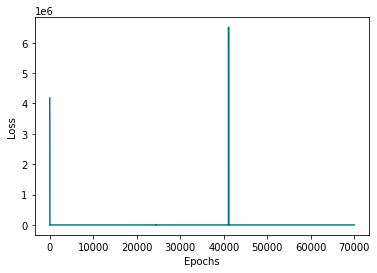

In [40]:
%%time

#this worked best
dinn = DINN(smallpox_data[0], smallpox_data[1], smallpox_data[2], smallpox_data[3], smallpox_data[4], smallpox_data[5], smallpox_data[6], smallpox_data[7], smallpox_data[8])

learning_rate = 1e-3
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(dinn.optimizer, factor=0.85, patience = 5000, verbose=True)
#scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-6, max_lr=1e-3, step_size_up=100, mode="triangular2", cycle_momentum=False)

dinn.scheduler = scheduler

try: 
  S_pred_list ,En_pred_list ,Ei_pred_list ,Ci_pred_list ,I_pred_list ,Q_pred_list ,U_pred_list ,V_pred_list = dinn.train(30000) #train
except EOFError:
  if dinn.save == 2:
    dinn.save = 3
    S_pred_list ,En_pred_list ,Ei_pred_list ,Ci_pred_list ,I_pred_list ,Q_pred_list ,U_pred_list ,V_pred_list = dinn.train(30000) #train
  elif dinn.save == 3:
    dinn.save = 2
    S_pred_list ,En_pred_list ,Ei_pred_list ,Ci_pred_list ,I_pred_list ,Q_pred_list ,U_pred_list ,V_pred_list = dinn.train(30000) #train

Text(0, 0.5, 'Loss')

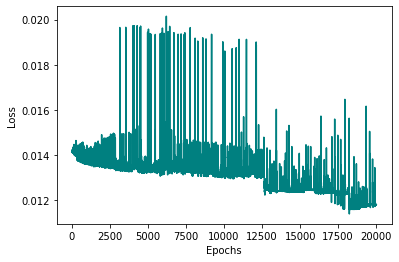

In [41]:
plt.plot(dinn.losses[50000:], color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss')

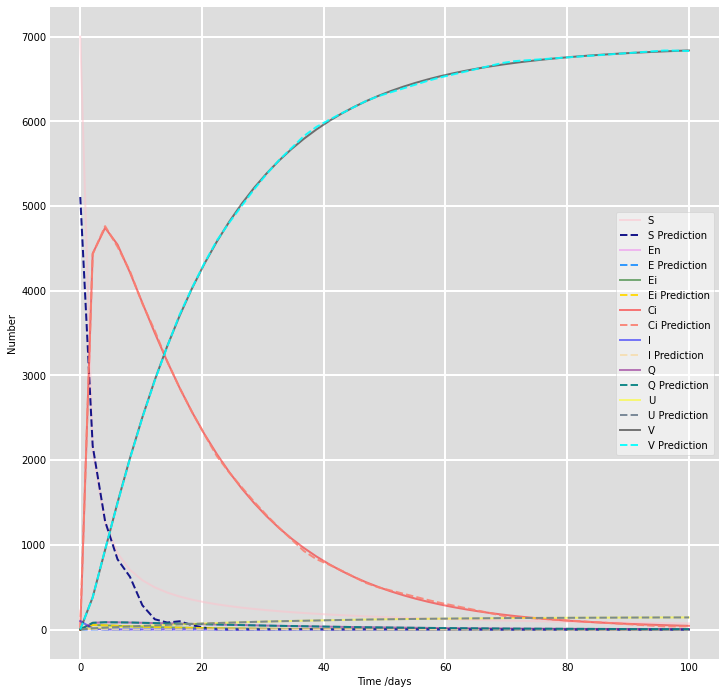

In [42]:
fig = plt.figure(facecolor='w', figsize=(12,12))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

ax.plot(smallpox_data[0], smallpox_data[1], 'pink', alpha=0.5, lw=2, label='S')
ax.plot(smallpox_data[0], S_pred_list[0].detach().numpy(), 'navy', alpha=0.9, lw=2, label='S Prediction', linestyle='dashed')

ax.plot(smallpox_data[0], smallpox_data[2], 'violet', alpha=0.5, lw=2, label='En')
ax.plot(smallpox_data[0], En_pred_list[0].detach().numpy(), 'dodgerblue', alpha=0.9, lw=2, label='E Prediction', linestyle='dashed')

ax.plot(smallpox_data[0], smallpox_data[3], 'darkgreen', alpha=0.5, lw=2, label='Ei')
ax.plot(smallpox_data[0], Ei_pred_list[0].detach().numpy(), 'gold', alpha=0.9, lw=2, label='Ei Prediction', linestyle='dashed')

ax.plot(smallpox_data[0], smallpox_data[4], 'red', alpha=0.5, lw=2, label='Ci')
ax.plot(smallpox_data[0], Ci_pred_list[0].detach().numpy(), 'salmon', alpha=0.9, lw=2, label='Ci Prediction', linestyle='dashed')

ax.plot(smallpox_data[0], smallpox_data[5], 'blue', alpha=0.5, lw=2, label='I')
ax.plot(smallpox_data[0], I_pred_list[0].detach().numpy(), 'wheat', alpha=0.9, lw=2, label='I Prediction', linestyle='dashed')

ax.plot(smallpox_data[0], smallpox_data[6], 'purple', alpha=0.5, lw=2, label='Q')
ax.plot(smallpox_data[0], Q_pred_list[0].detach().numpy(), 'teal', alpha=0.9, lw=2, label='Q Prediction', linestyle='dashed')

ax.plot(smallpox_data[0], smallpox_data[7], 'yellow', alpha=0.5, lw=2, label='U')
ax.plot(smallpox_data[0], U_pred_list[0].detach().numpy(), 'slategrey', alpha=0.9, lw=2, label='U Prediction', linestyle='dashed')

ax.plot(smallpox_data[0], smallpox_data[8], 'black', alpha=0.5, lw=2, label='V')
ax.plot(smallpox_data[0], V_pred_list[0].detach().numpy(), 'aqua', alpha=0.9, lw=2, label='V Prediction', linestyle='dashed')


ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
#ax.set_ylim([-1,50])
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [43]:
-print('alpha1: (goal 1)', round(dinn.alpha1.item(),2))
print('\nalpha2: (goal 0)', round(dinn.alpha2.item(),2))
print('\nbeta: (goal 0.0075): ', round(dinn.beta.item(),4))
print('\nmu (goal 5): ', round(dinn.mu.item(),2))
print('\nu: (goal 0.515151515): ', round(dinn.u.item(),2))
print('\ntao (goal 0.58): ', round(dinn.tao.item(),2))


print('\nerror:')
print('alpha1: ', round((1-round(dinn.alpha1.item(),2))/1,2)*100,'%')
print('alpha2: ', round((0-round(dinn.alpha2.item(),2))/1e-20,2)*100,'%')
print('beta: ', round((0.0075-round(dinn.beta.item(),4))/0.0075,2)*100,'%')
print('mu: ', round((5-round(dinn.mu.item(),2))/5,2)*100,'%')
print('u: ', round((0.515151515-round(dinn.u.item(),2))/0.515151515,2)*100,'%')
print('tao: ', round((0.58-round(dinn.tao.item(),2))/0.58,2)*100,'%')

AttributeError: ignored

In [ ]:
#vaccination! 

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Initial number of infected individuals, I0
I0 = 1
# Everyone else, S0, is susceptible to infection initially.
S0 = 2000
# Contact rate, beta, and mean recovery rate, mu.
beta, mu = dinn.beta, dinn.mu
# A grid of time points (in days)
t = np.linspace(0, 3, 100) 
#parameters
u = dinn.u
tao = dinn.tao
alpha1 = dinn.alpha1
alpha2 = dinn.alpha2

# The SIR model differential equations.
def deriv(y, t, beta, mu, u, tao, alpha1, alpha2):
    S, I = y
    dSdt = -beta * S * I + u * (t > tao) * alpha1 * (-S)
    dIdt = beta * S * I - mu * I + u * (t > tao) * alpha2 * (-I)
    return dSdt, dIdt

#add u = 0.5, get the corresponding tao, generate the SI data
# learn u (self.u), the corresponding tao (self.tao)

# Initial conditions vector
y0 = S0, I0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(beta, mu, u, tao, alpha1, alpha2))
S, I = ret.T

# Plot the data on two separate curves for S(t), I(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(tSI_vaccination_data[0], tSI_vaccination_data[1], 'navy', alpha=0.9, lw=2, label='Actual Susceptible')
ax.plot(t, S, 'violet', alpha=0.5, lw=2, label='Learnable Param Susceptible', linestyle='dashed')
ax.plot(tSI_vaccination_data[0], tSI_vaccination_data[2], 'dodgerblue', alpha=0.9, lw=2, label='Actual Infected')
ax.plot(t, I, 'darkgreen', alpha=0.5, lw=2, label='Learnable Param Infected', linestyle='dashed')
ax.set_xlabel('Time /days')
#ax.set_ylabel('Number (1000s)')
#ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [ ]:
#calculate relative MSE loss
import math

S_total_loss = 0
S_den = 0
I_total_loss = 0
I_den = 0
for timestep in range(len(t)):
  S_value = tSI_vaccination_data[1][timestep] - S[timestep]
  S_total_loss += S_value**2
  S_den += (tSI_vaccination_data[1][timestep])**2
  I_value = tSI_vaccination_data[2][timestep] - I[timestep]
  I_total_loss += I_value**2
  I_den += (tSI_vaccination_data[2][timestep])**2

S_total_loss = math.sqrt(S_total_loss/S_den)

I_total_loss = math.sqrt(I_total_loss/I_den)
print('S_total_loss: ', S_total_loss)
print('I_total_loss: ', I_total_loss)